## This Notebook covers predictive data analysis part

Predictive: What is likely to happen?


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import io

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense


/home/dulanj/Environments/py376/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.
/home/dulanj/Environments/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dulanj/Environments/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uin

## Load data from excel file

In [2]:
df = pd.read_excel('../data/Production Data Versaline.xlsx')
df = df.rename(columns={"Breakdowns and other delays": "BreakDowns", "Effective production time": "Eff Prod time"})
print(df.columns)
df.head()

Index(['Date', 'Product', 'Planned start Time', 'Actual Start Time',
       'Stop Time', 'Total time', 'Startup Delay', 'BreakDowns',
       'Eff Prod time', 'Operating Speed', 'Produced Qty', 'Rejects Qty',
       'Mix Usage', 'Mix Wastage', 'Mix yield', 'AR', 'PR', 'QR', 'OEE',
       'Mix Per Stick', 'Efficiency', 'Planned Qty'],
      dtype='object')


,Date,Product,Planned start Time,Actual Start Time,Stop Time,Total time,Startup Delay,BreakDowns,Eff Prod time,Operating Speed,...,Mix Usage,Mix Wastage,Mix yield,AR,PR,QR,OEE,Mix Per Stick,Efficiency,Planned Qty
0,2018-07-02,WB Chocolate,06:30:00,10:30:00,20:30:00,14.0,4.0,5.15,4.85,28880,...,7840.0,991.000,0.873597,0.346429,1.496754,0.873597,0.452976,0.0375,0.499675,NaN
1,2018-07-04,WB Vanilla,06:00:00,18:30:00,20:00:00,14.0,12.5,0.00,1.50,28880,...,1160.0,40.625,0.964978,0.107143,0.716049,0.964978,0.074033,0.0375,0.098710,NaN
2,2018-07-05,WB Vanilla,06:00:00,09:00:00,18:00:00,12.0,3.0,3.90,5.10,28880,...,7840.0,812.125,0.896413,0.425000,1.423384,0.896413,0.542274,0.0375,0.595438,NaN
3,2018-07-06,JJ Necto,06:00:00,09:00:00,21:00:00,15.0,3.0,5.18,6.82,28880,...,16000.0,2413.600,0.849150,0.454667,1.357663,0.849150,0.524167,0.0600,0.562595,NaN
4,2018-07-07,WB Vanilla,06:00:00,10:30:00,18:00:00,12.0,4.5,5.10,2.40,28880,...,7000.0,508.750,0.927321,0.200000,2.700617,0.927321,0.500868,0.0375,0.605216,NaN


### Calculate Rejects percentage and add as a colomn

Rejects percentage = Rejects Qty / (Total Qty + Rejects Qty)

In [3]:
# Add rejects percentage
def get_rejects_percentage(row):
    return row["Rejects Qty"]/(row["Produced Qty"]+row["Rejects Qty"])

df['Rejects Pct'] = df.apply (lambda row: get_rejects_percentage(row), axis=1)

### Fill the NAN values with the mean of the colomn

In [4]:
for val in ["Rejects Pct"]:#["Rejects Pct", "Mix yield"]
    df[val] = df[val].fillna(df[val].mean())
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                441 non-null    datetime64[ns]
 1   Product             441 non-null    object        
 2   Planned start Time  441 non-null    object        
 3   Actual Start Time   441 non-null    object        
 4   Stop Time           441 non-null    object        
 5   Total time          441 non-null    float64       
 6   Startup Delay       441 non-null    float64       
 7   BreakDowns          441 non-null    float64       
 8   Eff Prod time       441 non-null    float64       
 9   Operating Speed     441 non-null    int64         
 10  Produced Qty        441 non-null    int64         
 11  Rejects Qty         440 non-null    float64       
 12  Mix Usage           441 non-null    float64       
 13  Mix Wastage         441 non-null    float64       

### Select only the useful features
remove duplicate features such as start time and end time

In [5]:
useful_colomns = ["Product", "Produced Qty", "BreakDowns", "Startup Delay", "Total time", "Rejects Pct", "OEE"]
df = df[useful_colomns]
df.head(2)

,Product,Produced Qty,BreakDowns,Startup Delay,Total time,Rejects Pct,OEE
0,WB Chocolate,182640,5.15,4.0,14.0,0.126403,0.452976
1,WB Vanilla,29850,0.00,12.5,14.0,0.035022,0.074033


In [6]:
df.Product.unique()

array(['WB Chocolate', 'WB Vanilla', 'JJ Necto', 'MM Watermelon',
       'MM Orange', 'WB Chock Shock', 'WB Berry', '2-Bar Vanilla Faluda',
       'JJ Cream Soda', 'JJ Orange Crush ', 'Ice Cake', 'Bubble Gumy',
       'JJ Creamsoda', 'WB Vnilla', 'Bubble Gummy', 'Ice cake',
       'WB Chocok Shock', 'JJ Orange Crush'], dtype=object)

### Rename Duplicates products with the correct name

In [7]:
df = df.replace({'Product': {"JJ Orange Crush ": "JJ Orange Crush", 
                             "WB Chocok Shock": "WB Chock Shock",
                            "Ice cake": "Ice Cake",
                            "Bubble Gumy":"Bubble Gummy", 
                            "WB Vnilla": "WB Vanilla",
                            "JJ Creamsoda": "JJ Cream Soda"}})
for product in df.Product.unique():
    print("{:15} = {}".format(product, df[df["Product"] == product]["Product"].count()))

WB Chocolate    = 62
WB Vanilla      = 74
JJ Necto        = 45
MM Watermelon   = 51
MM Orange       = 65
WB Chock Shock  = 30
WB Berry        = 16
2-Bar Vanilla Faluda = 65
JJ Cream Soda   = 15
JJ Orange Crush = 8
Ice Cake        = 5
Bubble Gummy    = 5


In [8]:
print("Number of rows: {}".format(df.Product.count()))
df.info()

Number of rows: 441
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        441 non-null    object 
 1   Produced Qty   441 non-null    int64  
 2   BreakDowns     441 non-null    float64
 3   Startup Delay  441 non-null    float64
 4   Total time     441 non-null    float64
 5   Rejects Pct    441 non-null    float64
 6   OEE            441 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 24.2+ KB


In [9]:
# group_by_products = df.groupby(by=['Product'])
# product_data_avg = group_by_products.mean()
# product_data_count = group_by_products.count()
# print(product_data_avg)
# print(product_data_count)

In [10]:
for col in df.columns.values:
    print("{:20} = {}".format(col, df[col].nunique()))

Product              = 12
Produced Qty         = 433
BreakDowns           = 261
Startup Delay        = 130
Total time           = 208
Rejects Pct          = 301
OEE                  = 439


## Here we test different regression methods

In [11]:
def test_results(model, features, actual):
    y_pred = model.predict([features])
    print("Result: {}\nActual: {}".format(y_pred[0], actual))
    print("Error:{}\nSqured Error:{}".format(y_pred[0]-actual, (y_pred[0]-actual)**2))

### Data Preperation

#### Onehot encoding

In [12]:
# Products as a input
df['Product'] = pd.Categorical(df['Product'])
dfDummies = pd.get_dummies(df['Product'], prefix = 'prod')
# dfDummies.info()
df_p = pd.concat([df, dfDummies], axis=1)
# df_p.info()

In [13]:
# Select only one product
# df_p = df[df['Product']=="WB Chocolate"]
# df_p = df[df['Product']=="MM Orange"]

In [14]:
# Scale the data
y = df_p["OEE"]
X = df_p.drop(['Product', 'OEE'], axis = 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def scale(dataframe, scaler=None):
    colomns_to_scale = ["Produced Qty", "BreakDowns", "Startup Delay", "Total time", "Rejects Pct"]
    # Only scale relevenat features
    scaled_features = dataframe.copy()
    features = scaled_features[colomns_to_scale]
    if scaler is None:
        scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_features[colomns_to_scale] = features
    return scaled_features, scaler

X_train_s, scaler = scale(X_train)
X_test_s, _ = scale(X_test, scaler)
# X_train_s.head()
X_test_s.head()

,Produced Qty,BreakDowns,Startup Delay,Total time,Rejects Pct,prod_2-Bar Vanilla Faluda,prod_Bubble Gummy,prod_Ice Cake,prod_JJ Cream Soda,prod_JJ Necto,prod_JJ Orange Crush,prod_MM Orange,prod_MM Watermelon,prod_WB Berry,prod_WB Chock Shock,prod_WB Chocolate,prod_WB Vanilla
361,1.574481,1.237761,1.205744,2.137366,-0.641294,1,0,0,0,0,0,0,0,0,0,0,0
249,-1.034454,-0.818599,0.391848,-1.029216,-0.641294,1,0,0,0,0,0,0,0,0,0,0,0
271,-0.886922,-0.727756,2.368452,-0.181025,2.778066,0,0,0,0,0,0,0,0,0,1,0,0
434,0.659353,2.385689,0.895688,1.359857,0.071918,0,0,0,0,0,0,0,0,0,1,0,0
397,-1.062622,-0.958993,-0.809618,-1.758661,-0.641294,0,0,0,0,0,0,0,0,0,0,0,1


### Linear Regression

In [15]:
regr = LinearRegression() 
regr.fit(X_train, y_train) 
y_pred = regr.predict(X_test)
print("Accuracy:", r2_score(y_test, y_pred))

Accuracy: 0.8448161466480698


### Decision Tree 

In [16]:
# y = df_p["OEE"]
# X = df_p.drop(['Product', 'OEE'], axis = 1) 

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
# Hyper parameter Tuning for Decision Trees
# Number of features to consider at every split
criterion = ["mse", "friedman_mse", "mae"]
splitter = ["best", "random"]
max_features = ['auto', 'log2', 'sqrt']
max_features.append(None)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]  # Create the random grid
random_grid = {'criterion': criterion,
               'splitter': splitter,
                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = DecisionTreeRegressor()
print(rf.get_params().keys())
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)  # Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

{'criterion': ['mse', 'friedman_mse', 'mae'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'splitter': ['best', 'random']}
dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s


{'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'mae'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


In [18]:
regressor = DecisionTreeRegressor(splitter="best", criterion="mae", random_state=0, min_samples_split=5, 
                                  min_samples_leaf=2, max_features=None, max_depth=50)
# regressor = DecisionTreeRegressor(random_state=0)
print(regressor.fit(X_train,y_train))

y_pred = regressor.predict(X_test)
print("Accuracy:", r2_score(y_test, y_pred))

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')
Accuracy: 0.8343317707950609


In [19]:
number = 2
test_results(regressor, X_test.iloc[number], y_test.iloc[number])
# y_pred = regressor.predict([X.loc[number]])
# print("Features: {}\nResult: {}".format(X.loc[number], y_pred))

Result: 0.325280898876404
Actual: 0.355357142857143
Error:-0.030076243980738993
Squred Error:0.0009045804519889385


### Plotting the tree

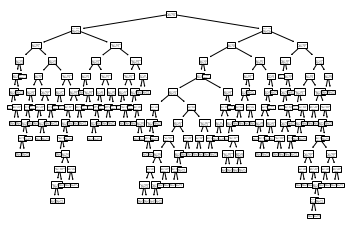

In [20]:
from sklearn import tree
t = tree.plot_tree(regressor)

['Produced Qty', 'BreakDowns', 'Startup Delay', 'Total time', 'Rejects Pct', 'prod_2-Bar Vanilla Faluda', 'prod_Bubble Gummy', 'prod_Ice Cake', 'prod_JJ Cream Soda', 'prod_JJ Necto', 'prod_JJ Orange Crush', 'prod_MM Orange', 'prod_MM Watermelon', 'prod_WB Berry', 'prod_WB Chock Shock', 'prod_WB Chocolate', 'prod_WB Vanilla']


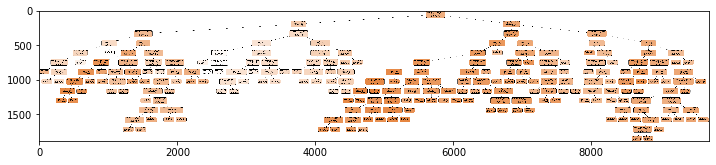

In [21]:


dot_data = io.StringIO()

plot_colomns = list(df_p.columns)
plot_colomns.remove('OEE')
plot_colomns.remove('Product')
print(plot_colomns)
export_graphviz(regressor, out_file=dot_data, feature_names=plot_colomns, class_names=["OEE"], rounded=True, filled=True)

filename = "Decision_Tree.png"
pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png(filename)

plt.figure(figsize=(12,12))
img = mpimg.imread(filename)
imgplot = plt.imshow(img)

plt.show()

### Scaling the data

## Support Vector Machine

In [22]:

svm_classifier = SVR(kernel='linear')         
svm_classifier.fit(X_train_s, y_train)
y_pred = svm_classifier.predict(X_test_s)

print("Accuracy:", r2_score(y_test, y_pred))

Accuracy: 0.804315810116353


### Random Forest

In [23]:
# Hyperparameter Tuning using Random Forest

def random_forest_hpt():
    n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
    # Number of features to consider at every split
    criterion = ["mse", "mae"]
    max_features = ['auto', 'log2', 'sqrt']
    max_features.append(None)
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]  # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                    'criterion': criterion,
                    'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    pprint(random_grid)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    print(rf.get_params().keys())
    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                                   random_state=42, n_jobs=-1)  # Fit the random search model
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)

# random_forest_hpt() 

In [24]:
# random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest_regressor = RandomForestRegressor(n_estimators=800, criterion='mae', max_features='auto', max_depth=80, 
                                                min_samples_split=5, min_samples_leaf=1, random_state=0)

random_forest_regressor.fit(X_train_s, y_train)
y_pred_t = random_forest_regressor.predict(X_test_s)
print("Accuracy:", r2_score(y_test, y_pred_t))

Accuracy: 0.8866850503660298


### Neural network

Instructions for updating:
Colocations handled automatically by placer.
Input Dimention: 17
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseLayer-1 (Dense)         (None, 192)               3456      
_________________________________________________________________
DenseLayer-2 (Dense)         (None, 64)                12352     
_________________________________________________________________
DenseLayer-3 (Dense)         (None, 16)                1040      
_________________________________________________________________
DenseLayer-4 (Dense)         (None, 1)                 17        
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Accuracy: 0.9237331254578596


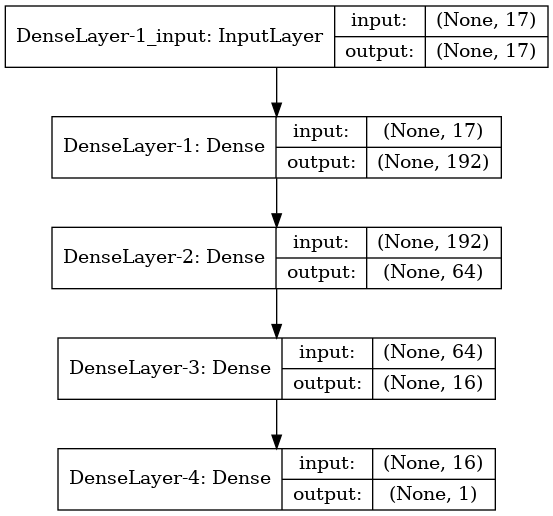

In [25]:
model = Sequential()
input_dim = len(X_train_s.columns)
model.add(Dense(192, input_dim=input_dim, activation='relu', name="DenseLayer-1"))
model.add(Dense(64, activation='relu', name="DenseLayer-2"))
model.add(Dense(16, activation='relu', name="DenseLayer-3"))
model.add(Dense(1, activation='linear', name="DenseLayer-4"))
print("Input Dimention: {}".format(input_dim))
print(model.summary())

# compile the keras model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.fit(X_train_s, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)

y_pred = model.predict(X_test_s)
print("Accuracy:", r2_score(y_test, y_pred))

# SAve model as image
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [26]:
number = 3
test_results(regressor, X_test_s.iloc[number], y_test.iloc[number])

Result: 0.336980920321386
Actual: 0.590192043896313
Error:-0.253211123574927
Squred Error:0.06411587310207693
